#  Hidden Markov Model with Gaussian-distributed observed variables

The aim of this notebook is to implement the EM algorithm of an HMM with multinomial latent variable and Gaussian-distributed observed variables.

In [3]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

In [4]:
%config InlineBackend.figure_format = "retina"

Let ${\bf X}=\{{\bf x}_n \vert {\bf x}_n \in \mathbb{R}^M\}_{n=1}^N$ be an sequential dataset of observed variables. We define a Hidden Markov Model (HMM) by introducing a set of unobserved (latent) variables ${\bf Z}=\{{\bf z}_n\}_{n=1}^N$. We define the relationship between ${\bf X}$ and ${\bf Z}$ as the following graph:

![Hidden Markov Model](https://imgur.com/1YC0iu0.png)

The joint distribution of an HMM is given by

$$
    p({\bf x}_1, \ldots, {\bf x}_n, {\bf z}_1, {\bf z}_N) = p({\bf z}_1)\prod_{n=1}^N p({\bf z}_n\vert {\bf z}_{n-1})\prod_{n=1}^N p({\bf x}_n \vert {\bf z}_n)
$$

With 

$$
    p({\bf z}_1\vert\boldsymbol\pi) = \prod_{k=1}^K \pi_k^{z_{1k}}
$$

We define the *emission* probabilities as

$$
p({\bf x}_n\vert {\bf z}_n, \boldsymbol\phi) = \prod_{k=1}^K p({\bf x}_n\vert\phi_k)^{z_{nk}} = \prod_{k=1}^K \left(\mathcal{N}({\bf x}_n\vert \boldsymbol\mu_k, \boldsymbol\Sigma_k)\right)^{z_{nk}}
$$

## HMM via the EM algorithm

In order to find the values $\boldsymbol\theta = \{\boldsymbol\pi, A, \boldsymbol\phi\}$, we make use of the EM algorithm. We perform a step of the EM algorith for an HMM as follows:

* **E-Step**: Compute $p({\bf Z}\vert{\bf X}, \boldsymbol\theta)$
* **M-Step**: Find $\boldsymbol\theta^{\text{new}}=\arg\max_{\boldsymbol\theta} Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}})$.

----

By writing the expected complete-data log-likelihood, we obtain an expression of the form

$$
   Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{k=1}^K \log\pi_k \gamma(z_{1k}) + \sum_{n=2}^N\sum_{j=1}^K\sum_{k=1}^K \xi(z_{n-1,j}, z_{n,k}) \log A_{jk} + \sum_{n=1}^N\sum_{k=1}^K \log p({\bf x}_n\vert\phi_k) \gamma(z_{nk})
$$

With updating equations


### E-Step

* $\gamma(z_{nk}) = \mathbb{E}[z_{nk}]$
* $\xi(z_{n-1,j}, z_{n,k}) = \mathbb{E}[z_{n-1, j} \cdot z_{n,k}]$

### M-Step

The M-step updating equations become

$$
    \pi_k = \frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}
$$


$$
    A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, k}, z_{nk})}{\sum_{l=1}^K\sum_{n=2}^N \xi(z_{n-1, k}, z_{nl})}
$$

To compute $\forall n,k,k:\gamma(z_{nk}), \xi(z_{n-1, j}, z_{nk})$, we require to obtain the values for

$$
    \gamma({\bf z}_n) = \frac{ \alpha({\bf z}_n)\beta({\bf z}_n) }{p({\bf X})}
$$

$$
    \xi({\bf z}_{n-1}, {\bf z}_n) = \frac{\alpha({\bf z}_{n-1}) p({\bf x}_n\vert {\bf z}_n) p({\bf z}_{n-1}\vert {\bf z}_n) \beta({\bf z}_n)}{p({\bf X})}
$$


Where $\alpha({\bf z}_n)$ and $\beta({\bf z})$ are recursive relations of the form

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

$$
    \beta({\bf z}_n) = \sum_{{\bf z}_{n+1}} p({\bf x}_{n+1}\vert{\bf z}_{n+1})p({\bf z}_{n+1} \vert {\bf z}_n)
$$


With initial conditions

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$
* $\beta(z_{Nk}) = 1$

$\alpha$ and $\beta$ are respectively known as the *Forward Message Passing* and *Backwards Message Passing*

### Modeling spread between MXN and BRL

* <strong style="color:crimson">Note</strong>: This is not a perfect example to use an HMM, as the bimodality in the distribution appears to correspond to different time periods and are not time indepenent.

In [94]:
def download_fx_daily(from_symbol, to_symbol, api_key):
    """
    Download the historical data of to_symbol currency
    in terms of from_symbol.
    
    Obtain your api from
            https://www.alphavantage.co/support/#api-key
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "FX_DAILY",
        "from_symbol": from_symbol,
        "to_symbol": to_symbol,
        "outputsize": "full",
        "datatype": "csv",
        "apikey": api_key
    }
    
    r = requests.get(url, params=params)
    df = pd.read_csv(StringIO(r.text), index_col=0)
    df = df.set_index(pd.to_datetime(df.index)).sort_index()
    
    return df

In [95]:
apikey = os.environ["AVANTAGE_API"]
df_mxn = download_fx_daily("MXN", "USD", apikey)
df_brl = download_fx_daily("BRL", "USD", apikey)
df = (df_brl - df_mxn).dropna()

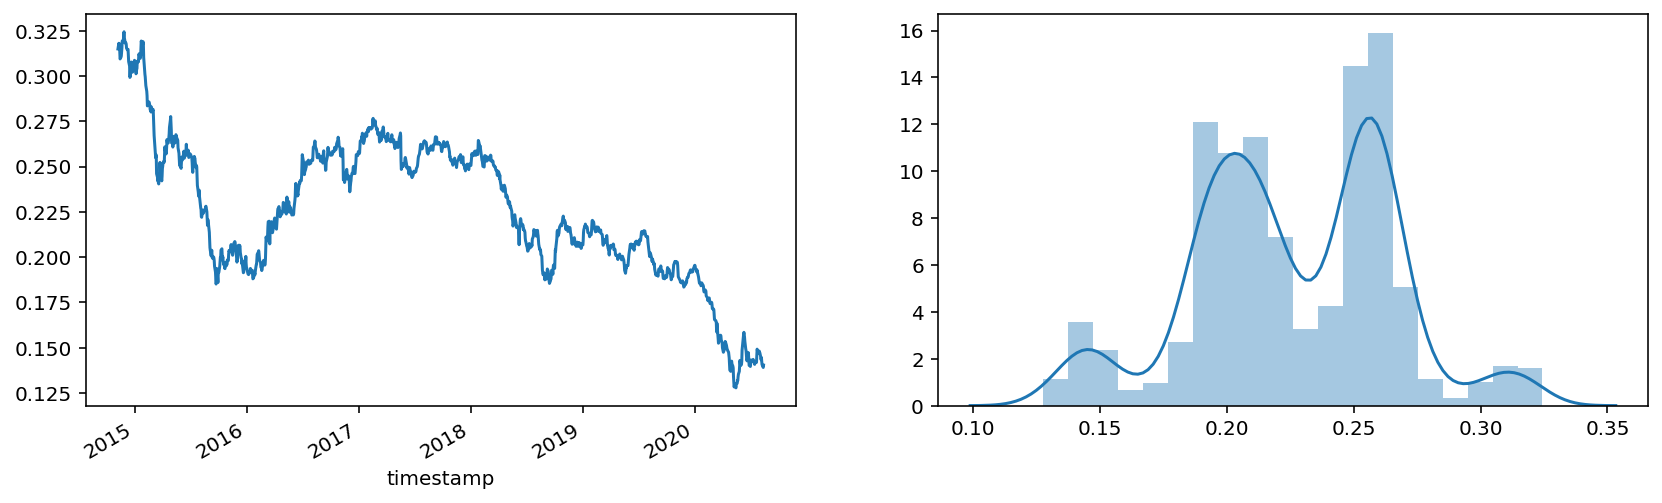

In [159]:
df_mxn_brl = (df["high"] + df["low"]) / 2

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df_mxn_brl.plot(ax=ax[0])
sns.distplot(df_mxn_brl, ax=ax[1])

### Implementing the forward-message-passing and backwards-message-passing

In [150]:
from scipy.stats import norm

In [169]:
from numpy.random import random, seed
seed(314)

K = 3
# initial parameters for the latent variables
pi = random(K)
pi = pi / pi.sum()
A = random((K, K))
A = A / A.sum(axis=1, keepdims=True)

# Initial parameters for the observed distribution
mus = random(K)
sigmas = random(K)

In [174]:
z = np.arange(K)

seed(314)
n_samples = 500
samples = np.zeros(n_samples)
zi = np.random.choice(z, p=pi)

for n in range(n_samples):
    N = norm(loc=mus[zi], scale=sigmas[zi])
    samples[n] = N.rvs()
    
    zi = np.random.choice(z, p=A[zi])

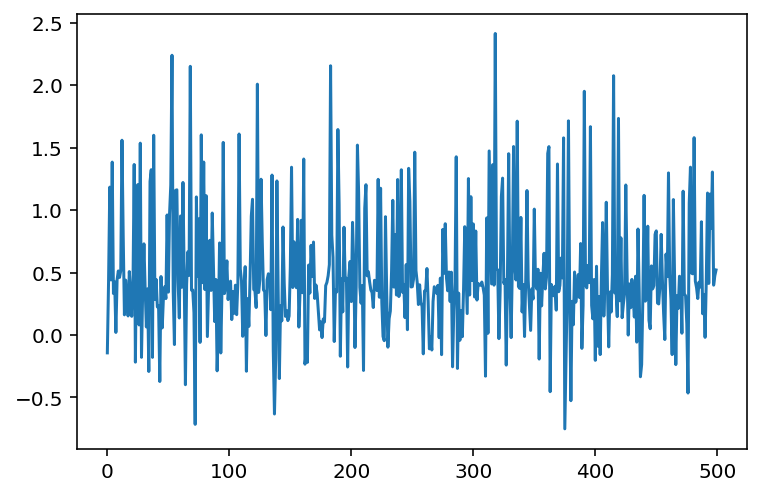

In [175]:
plt.plot(samples)

#### Forward-message-passsing

$$
    \alpha({\bf z}_n) = p({\bf x}_n\vert{\bf z}_n)\sum_{{\bf z}_{n-1}} \alpha({\bf z}_{n-1})p({\bf z}_n\vert {\bf z}_{n-1})
$$

* $\alpha(z_{1k}) = \pi_k p(x_1\vert\phi_k)$

In [178]:
N = norm(loc=mus, scale=sigmas)

In [195]:
# Initial "message"
a1 = pi * N.pdf(df_mxn_brl.iloc[0])

# Second "message"


array([0.58439493, 1.13090048, 0.0668723 ])

In [204]:
(a1[:, None] * A).sum(axis=0, keepdims=True)

array([[0.62778392, 0.40696033, 0.74742346]])